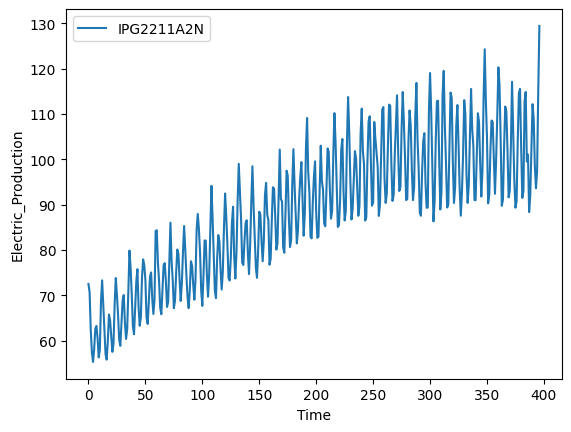

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy

from sklearn.linear_model import LinearRegression


data = pd.read_csv('data/Electric_Production.csv')
dates, ts = data.DATE, data.IPG2211A2N

L = 30
ts = ts[:len(ts)//L * L]
time = np.arange(len(ts))

data.plot()
# plt.plot(dates, ts)

# ys = dates[::60]
# labels = dates[::60]

# plt.xticks(ys,labels, rotation='vertical')
plt.ylabel('Electric_Production')
plt.xlabel('Time')
plt.show()

### Начальные параметры

In [39]:
lr = LinearRegression()
lr.fit(time.reshape(-1, 1), ts.fillna(0).values.reshape(-1, 1))

a0, b0 = lr.coef_, lr.intercept_
xl = (a0 * time + b0)[0]

In [40]:
k = len(ts) // L

In [41]:
len(ts), L, k

(390, 30, 13)

In [42]:
L

30

In [43]:
F_init = []

for p in range(L):
    temp = []
    for i in range(1, k):
        temp.append(ts[i*L - p] / xl[i*L - p])
    
    F_init.append(1/k * sum(temp))
    
F_init = np.array(F_init).T[0]

In [44]:
b = np.zeros(len(ts))
b[0] = b0

a = np.zeros(len(ts))
a[0] = a0

F = np.zeros(len(ts)+L-2)
F[:L] = F_init

alpha, beta, gamma = 0.4, 0.3, 0.3

for t in range(1, len(ts)):
    b[t] = alpha * ts[t]/F[t] + (1 - alpha) * (b[t-1] + a[t-1])
    a[t] = beta * (b[t] - b[t-1]) + (1 - beta) * a[t-1]
    F[t+L-2] = gamma * ts[t]/b[t] + (1 - gamma) * F[t]

In [45]:
ts_hat = []
for t in range(1, len(ts)):
    ts_hat.append((a[t] + b[t]) * F[t])

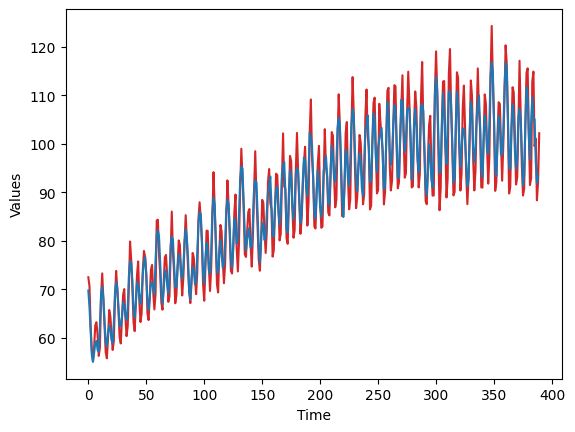

In [46]:
plt.plot(ts, color='tab:red')
plt.plot(ts_hat, color='tab:blue')

plt.ylabel('Values')
plt.xlabel('Time')
plt.show()

### Модель Хольта-Винтерса

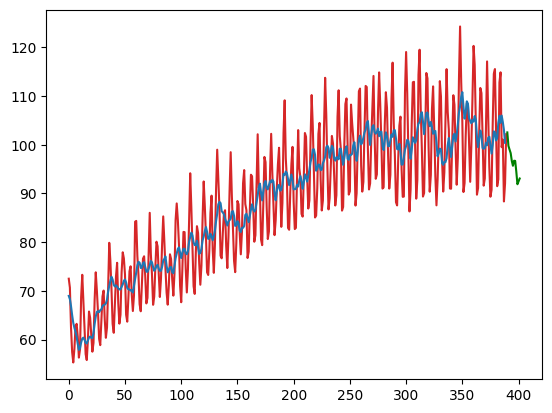

In [47]:
def Holt_Winters(ts, time, L, tau, alpha, beta, gamma):
    lr = LinearRegression()
    lr.fit(time.reshape(-1, 1), ts.values.reshape(-1, 1))
    a0, b0 = lr.coef_, lr.intercept_
    
    xl = (a0 * time + b0)[0]
    k = len(ts) // L
    
    F_init = []

    for p in range(L):
        temp = []
        for i in range(1, k):
            temp.append(ts[i*L - p] / xl[i*L - p])
        
        F_init.append(1/k * sum(temp))
        
    F_init = np.array(F_init).T[0]
    
    
    b = np.zeros(len(ts))
    b[0] = b0

    a = np.zeros(len(ts))
    a[0] = a0

    F = np.zeros(len(ts)+L-2)
    F[:L] = F_init

    for t in range(1, len(ts)):
        b[t] = alpha * ts[t]/F[t] + (1 - alpha) * (b[t-1] + a[t-1])
        a[t] = beta * (b[t] - b[t-1]) + (1 - beta) * a[t-1]
        F[t+L-2] = gamma * ts[t]/b[t] + (1 - gamma) * F[t]
    
    
    ts_hat = []
    for t in range(1, len(ts)):
        ts_hat.append((a[t] + b[t]) * F[t])

    # F[(np.arange(tau)+1 - L)]
    prediction = (a[-1]*(np.arange(tau)+1) + b[-1]) * F[-L + np.arange(tau)]   
    
    return a, b, F, ts_hat, prediction

tau, alpha, beta, gamma = 12, 0.1, 0.3, 0.1

a, b, F, ts_hat, prediction = Holt_Winters(ts, time, L, tau, alpha, beta, gamma)

plt.plot(ts, color='tab:red')
plt.plot(ts_hat, color='tab:blue')
plt.plot(np.arange(tau)+len(ts), prediction, color='green')

plt.show()

### Подбор параметров

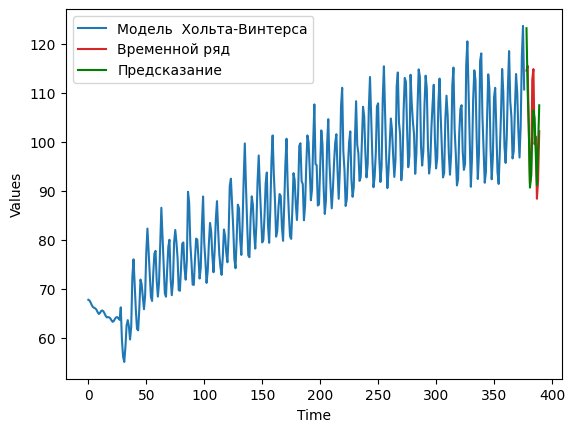

In [48]:
from sklearn.metrics import mean_squared_error
from scipy.optimize import minimize

train, val, test = ts[:-24], ts[-24:-12], ts[-12:]

def objective_fun(alpha, beta, gamma):
    a, b, F, ts_hat, prediction = Holt_Winters(train, np.arange(len(train)), L, 12, alpha, beta, gamma)
    
    return np.sqrt(mean_squared_error(prediction, val))


opt = minimize(lambda x: objective_fun(x[0], x[1], x[2]), bounds=[(0.05, 1), (0.05, 1), (0.1, 1)], x0=[0.3, 0.4, 0.3])
a, b, F, ts_hat, prediction = Holt_Winters(ts[:-12], np.arange(len(ts[:-12])), L, 12, opt.x[0], opt.x[1], opt.x[2])

plt.plot(ts_hat, color='tab:blue', label='Модель  Хольта-Винтерса')
plt.plot(np.arange(tau)+len(train)+len(val), ts[-12:], label='Временной ряд', color='tab:red')
plt.plot(np.arange(tau)+len(train)+len(val), prediction, color='green', label='Предсказание')

plt.ylabel('Values')
plt.xlabel('Time')
plt.legend()
plt.show()